<strong><font size="8">A1</font></strong>

In [40]:
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs #for removing heartbeats
import numpy
import matplotlib
import matplotlib.pyplot as plt
import os
import pathlib

data_path = mne.datasets.sample.data_path()

print(f"{mne.__version__=}")
print(data_path)

mne.__version__='1.9.0'
C:\Users\Peter\mne_data\MNE-sample-data


<strong><font size="6">1.1</font></strong>

In [41]:
raw_path = os.path.join(data_path, "MEG", "sample", "sample_audvis_raw.fif") #finds sample data in storage

raw = mne.io.read_raw_fif(raw_path, preload=True) #preloads data into memory for processing

# raw.crop(0, 60).load_data() #saves only first 60 seconds to memory

Opening raw data file C:\Users\Peter\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<strong><font size="6">1.2</font></strong>

In [43]:
filt_raw = raw.copy().filter(l_freq=1, h_freq=40) #bandpass from 1 to 40 Hz, deals w/ low-frequency drift
reconst_raw = filt_raw.copy() #copy of filtered data to plot out comparison later
# reconst_raw = raw.copy()

#identifies and stores ICA components
ica = ICA(n_components=35, max_iter="auto", random_state=97) #fast ICA model
ica.fit(filt_raw)
ica

ica.exclude = []
# find which ICs match the ECG pattern
ecg_indices, ecg_scores = ica.find_bads_ecg(raw, method="correlation", threshold="auto")

ica.exclude = ecg_indices
ica.apply(reconst_raw) #removes the found ICA components from the raw data, creating a reconstructed raw dataset (filtered)

#----------------------# PLOTTING #----------------------#
# plot ICs applied to raw data, with ECG matches highlighted
ica.plot_sources(raw, show_scrollbars=False)
#plots # of raw channels(since n_channels == len(raw.ch_names), and does not remove DC components 
# filt_raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names)//10, remove_dc=False) 
filt_raw.plot(proj=False, n_channels=len(raw.ch_names)//5, remove_dc=False) 
#plots reconstructed data, with filtering and removing of ICA components 
# reconst_raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names)//10, remove_dc=False)
reconst_raw.plot(proj=False, n_channels=len(raw.ch_names)//5, remove_dc=False) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1983 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.9s


Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 35 components
Fitting ICA took 18.3s.
Reconstructing ECG signal from Magnetometers
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying ICA to Raw instance
    Transforming to ICA space (35 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components
Creating RawArray with float64 data, n_channels=36, n_times=166800
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']


Channels marked as bad:
['MEG 2443', 'EEG 053']
Channels marked as bad:
['MEG 2443', 'EEG 053']


<strong><font size="6">1.3 (A)</font></strong>

320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]

There are 6 types of events. 72 Auditory/Left, 73 Auditory/Right, 73 Visual/Left, 71 Visual/Right, 15 Smiley, and 16 ButtonPress events occured.



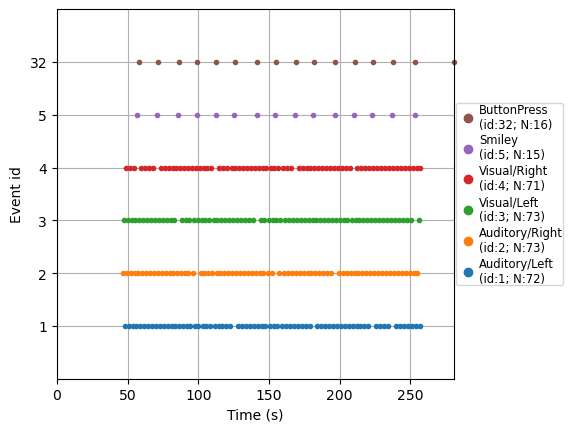

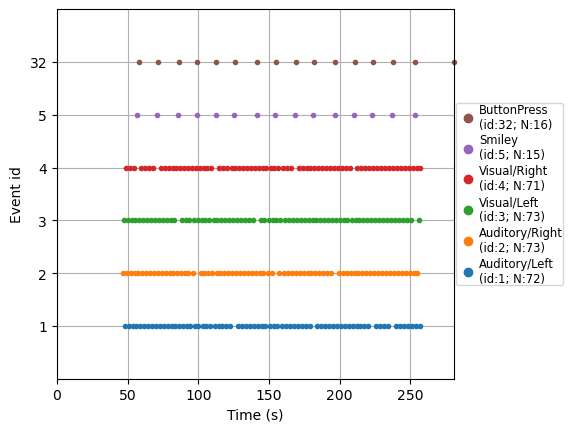

In [53]:
events = mne.find_events(raw, stim_channel="STI 014")
eventTypes, eventCounts = numpy.unique(events[:, 2], return_counts=True)

eventDict = {"Auditory/Left": 1, "Auditory/Right": 2,"Visual/Left": 3, "Visual/Right": 4, "Smiley": 5, "ButtonPress": 32} #includes all possible events, including those dropped in tutorial

print("\nThere are 6 types of events.", eventCounts[0], "Auditory/Left,", eventCounts[1], "Auditory/Right,", eventCounts[2], "Visual/Left,", eventCounts[3], "Visual/Right,", eventCounts[4], "Smiley, and", eventCounts[5], "ButtonPress events occured.\n")

mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=eventDict) #plots the events w/ sampling freqency of the raw data (otherwise would get by sample instead of by time)

<strong><font size="6">1.3 (B)</font></strong>

1. The events appear to be fairly distributed in time. There is not very much clustering in the data, meaning that we can say events of the same type are NOT clusterd in time. However, we do see that there are small breaks, so while in general the data appears evenly across time there are smaller subclusters. 
2. Since the events all start at roughly the same time (just under 50 seconds) and end at around the same time (just over 250 seconds), as well as having nearly no breaks in the data, it seems that the events are predictable. There appear to be breaks in the audio and visual data, but this occurs seemlingly in line with "Face" for "Visual" data and "ButtonPress" for "Auditory" data. Face and ButtonPress data occurs at evenly spaced intervals, except for one outlier occuring right at the end of the data for ButtonPress. In general, the events are predictable. 
3. Since the stimuli seem to be predictable and correlative, I would imagine that the time distribution could affect the brain response. The subjects of the experiments may begin to predict when certain stimuli will be introduced, which may interfere w/ the brain response.

<strong><font size="6">1.4</font></strong>

Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 320 events and 541 original time points ...
0 bad epochs dropped
Projections have already been applied. Setting proj attribute to True.


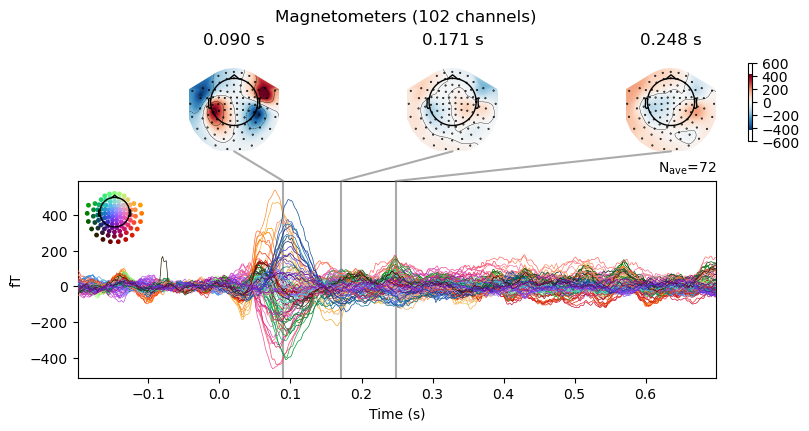

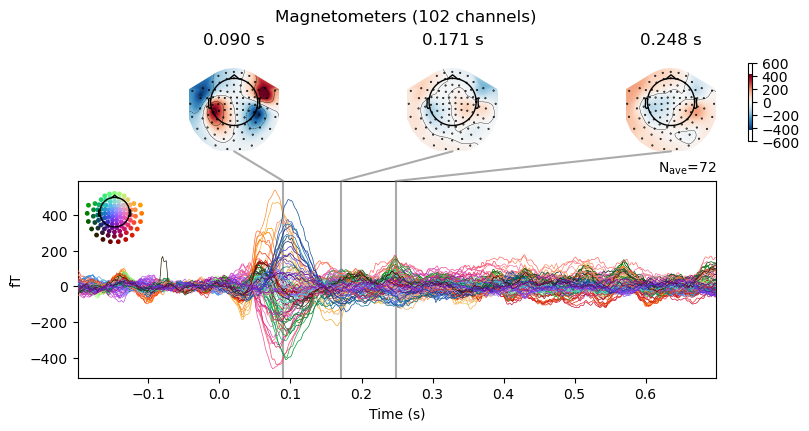

In [51]:
epochs = mne.Epochs(raw, events, event_id=eventDict, tmin=-0.2, tmax=0.7, picks='mag', preload=True) #takes only magnometer data, from 200ms before and 700ms after each event
evoked = epochs["Auditory/Left"].average() #takes just the left auditory data

evoked.plot_joint()